# Self-Driving Car Engineer Nanodegree

# Project: **Advanced Lane Finding** 

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository or in the repository folder included with the workspace.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


- The images for camera calibration are stored in the folder called `camera_cal`.  
- The images in `test_images` are for testing your pipeline on single frames.  
- If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  


- To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    
- The video called `project_video.mp4` is the video your pipeline should work well on.  


- The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  
- The `harder_challenge.mp4` video is another optional challenge and is brutal!



## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
### Common imports, variables, functions

In [138]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import time
%matplotlib inline


# Function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvers = cv2.calibrateCamera(objpoints,imgpoints,img.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def display2ImagesSideBySide(img1,txt1,img2,txt2) :
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(txt1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(txt2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def saveImageOutputAndShowVsImageInput(saveFolder, filenames_in, fname, img_in, legend_in,
                                       img_out, legend_out,saveGray=False) :
    # save and show output images -- for Writeup illustrations
    if saveImages :
        if not saveGray :
            mpimg.imsave( saveFolder + '/' + fname,img_out)
        else : 
            mpimg.imsave( saveFolder + '/' + fname,img_out,cmap='gray')
    # display exemple for first chessboard image
    if fname == filenames_in[0] :
        display2ImagesSideBySide(img_in,legend_in,img_out,legend_out)
        
def saveImageOutputAndShow(saveFolder, filenames_in, fname, img_out,saveGray=False) :
    # save and show output images -- for Writeup illustrations
    if saveImages :
        if not saveGray :
            mpimg.imsave( saveFolder + '/' + fname,img_out)
        else : 
            mpimg.imsave( saveFolder + '/' + fname,img_out,cmap='gray')
    # display exemple for first chessboard image
    if fname == filenames_in[0] :
        plt.imshow(img_out)
    

def getSizeImages() : 
    # Make a list of Thresholded Binary Images
    filenames = os.listdir(testImageFolder)
    img = mpimg.imread(testImageFolder + '/' + filenames[0])
    return img.shape[1], img.shape[0]


# keep track of things like where your last several detections of the lane lines 
# were and what the curvature was, so you can properly treat new detections. 
# To do this, it's useful to define a Line() class to keep track of all the 
# interesting parameters you measure from frame to frame.
# Define a class to receive the characteristics of each line detection

class Line():
    def __init__(self):
        self.reset()
    def reset(self):
        # set all members to their initial value
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
        
        
# perspective transform to rectify binary image ("birds-eye view").

# source points on straigt_lines1.jpg [253,678],[1054,678],[608,441],[672,441]
# destination points : [253,ySize],[1054,ySize],[253,0],[1054,0]
# But lines too long 
# 2nd selection : 
# source points on straigt_lines1.jpg [265,678],[1042,678],[582,460],[702,460]
# destination points : [265,ySize],[1042,ySize],[265,0],[1042,0]



def getPerspectiveTransformMatrix():
        
    #define 4 source points src = np.float32([[,],[,],[,],[,]])
    src=np.float32([[265,678],[1042,678],[582,460],[702,460]])
    #define 4 destination points src = np.float32([[,],[,],[,],[,]])
    dst=np.float32([[265,ySize-1],[1042,ySize-1],[265,0],[1042,0]])

    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    return M, Minv

# To handle read/write image folders
output_folder = "output_images"
cameraCalFolder = "camera_cal"
chessBoardCornersFolder = output_folder + "/001_cameraCalDisplayCorners"
chessBoardUndistortedFolder = output_folder + "/002_chessboardUndistorted"
testImageFolder = "test_images"
undistortedTestImgFolder = output_folder + "/003_undistortedTestImages"
thresholdedBinaryImgFolder = output_folder + "/004_thresholdedBinaryImages"
thresholdedBinaryImgGrayFolder = output_folder + "/005_thresholdedBinaryImagesGray"
topDownViewFolder = output_folder + "/006_topDownViews"
topDownViewBinaryFolder = output_folder + "/007_topDownViewsBinary"
slidingWindowsLanePixelsBoundariesFolder = output_folder + "/008_slidingWindowsLanePixelsLaneBoundaries"
detectedLaneBoundariesFolder = output_folder + "/009_detectedLaneBoundaries"
imgBoundariesTextFolder = output_folder + "/010_imgBoundariesText"

# Flag saveImages
saveImages = False

# Those variables will be used extensively later on
# To avoid to calculate image sizes again and again and again
xSize, ySize = getSizeImages()

# Those variables will be used later on as well --> extracted from loops
M, Minv = getPerspectiveTransformMatrix()

# Define conversions in x and y from pixels space to meters
#ym_per_pix = 30/720 # meters per pixel in y dimension --> 0.0416
ym_per_pix = 3/(601-546) # meters per pixel in y dimension --> 0.066
# 2nd image calculation : 
#xm_per_pix = 3.7/1280 # meters per pixel in x dimension --> 2.89 10-3
xm_per_pix = 3.7/(1037-267) # meters per pixel in x dimension --> 4.80 10-3
# 2nd image calculation : 3.7/(1047-278)

# manual check deviation vs Center : Center at pix 1280/2 = 640.
    # (1037-267)/2 = 385
    # 385 - 640 =  -255 * 3.7/(1037-267) =  -1.22m
    

# Need to create an instance of the Line() class for the left and right lane lines 
# to keep track of recent detections and to perform sanity checks.

rightLine = Line()
leftLine = Line()

# counter frames using sliding window for lane search
nbSlidingWindowSearch = 0
# counter frames using Prior Line search lane search
nbPriorLineSearch = 0

### Chessboard corner detection

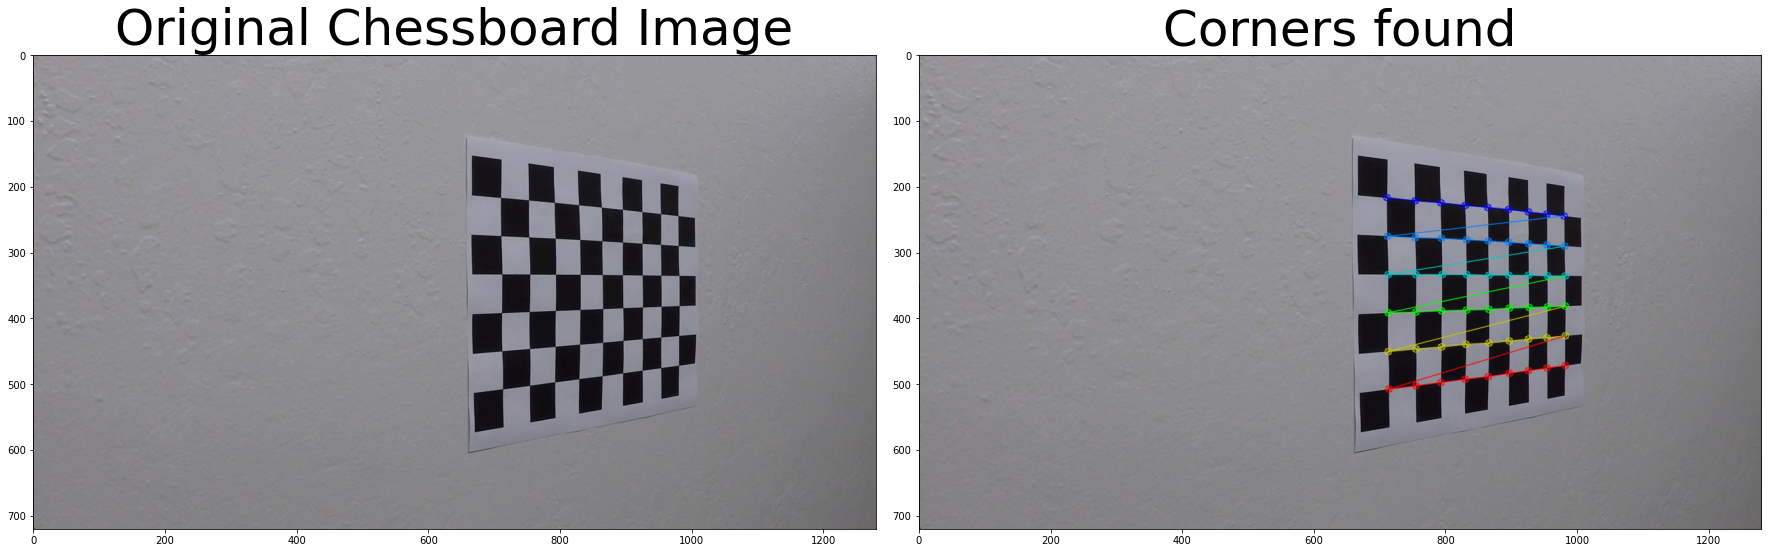

In [86]:
# images for camera calibration are stored in the folder called `camera_cal`.  
# need to set your chessboard size to 9x6 for the project instead of 8x6 as in the lesson.

# multiple pictures of the chessboard against a flat surface, 
# then we’ll be able to detect any distortions by  looking at the difference between apparent 
# size and the shape of squares in these images, and the size and shape that they actually are.
#    • Then we’ll use that information to calibrate our camera.
#    • Create a transform that maps distorted point to undistorded points.
#    • And finally, undistort any images.

def findChessboardCorners(img, objpoints, imgpoints) :
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # convert image to gray scale, 
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
         
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    return ret, corners, objpoints, imgpoints


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')
filenames = os.listdir(cameraCalFolder)

# counter to display only result for 1st image
nb = 0
    
# Step through the list and search for chessboard corners
for fname in filenames :
    img = mpimg.imread(cameraCalFolder + '/' + fname)
    img2 = np.copy(img)
    
    ret, corners, objpoints, imgpoints = findChessboardCorners(img, objpoints, imgpoints)
    
    if ret == True :
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                
        # save output images -- for Writeup illustrations
        if saveImages :
            mpimg.imsave( chessBoardCornersFolder + '/' + fname.replace(cameraCalFolder + '/',''),img,cmap='gray')
    
        # Display exemple for first chessboard image
        #if fname == filenames[0] : # not sure why but it does not work !!!
        if nb == 0 :
            display2ImagesSideBySide(img2,'Original Chessboard Image',img,'Corners found')
        nb = nb + 1
            

### Camera Calibration

In [87]:
# Now based on al objpoints + imgpoints, will compute camera calibration matrix 
# and distortion coefficients (mtx and dist)
#ret, mtx, dist, rvecs, tvers = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
ret, mtx, dist, rvecs, tvers = cv2.calibrateCamera(objpoints,imgpoints,(xSize,ySize),None,None)

### Test undistortion

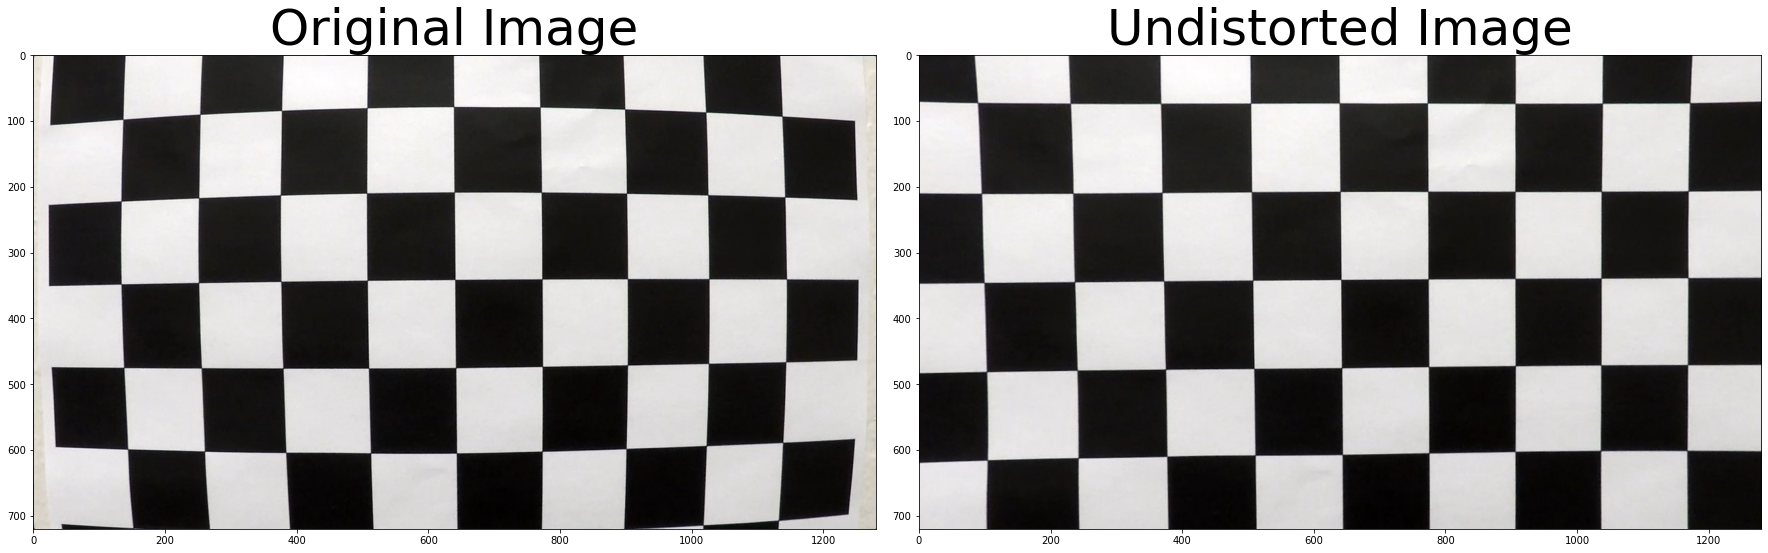

In [88]:
# Just to check, will undistort and show/save chessboard images

# Make a list of calibration images
filenames = os.listdir(cameraCalFolder)

for fname in filenames:

    img = mpimg.imread(cameraCalFolder + '/' + fname)

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    saveImageOutputAndShowVsImageInput(chessBoardUndistortedFolder, filenames, fname , img, 'Original Image',
                                       undist, 'Undistorted Image')


## Apply a distortion correction to raw images.

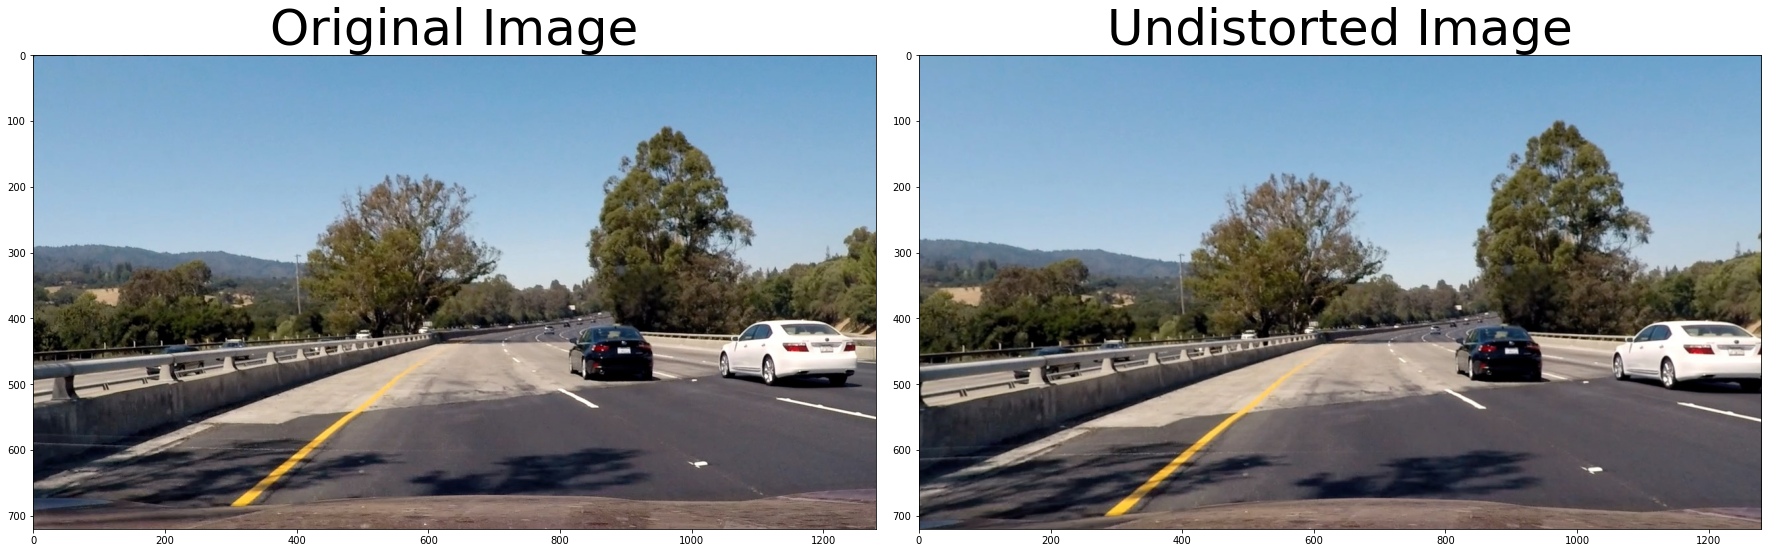

In [125]:
# Make a list of test images
filenames = os.listdir(testImageFolder)

for fname in filenames :
    # Read in image 
    img = mpimg.imread(testImageFolder + '/' + fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    saveImageOutputAndShowVsImageInput(undistortedTestImgFolder, filenames, fname , img, 'Original Image',
                                       undist, 'Undistorted Image')
        

## Use color transforms, gradients, etc., to create a thresholded binary image.

['test4.jpg', 'test1.jpg', 'straight_lines1.jpg', 'straight_lines2.jpg', 'test6.jpg', 'test3.jpg', 'test5.jpg', 'test2.jpg']


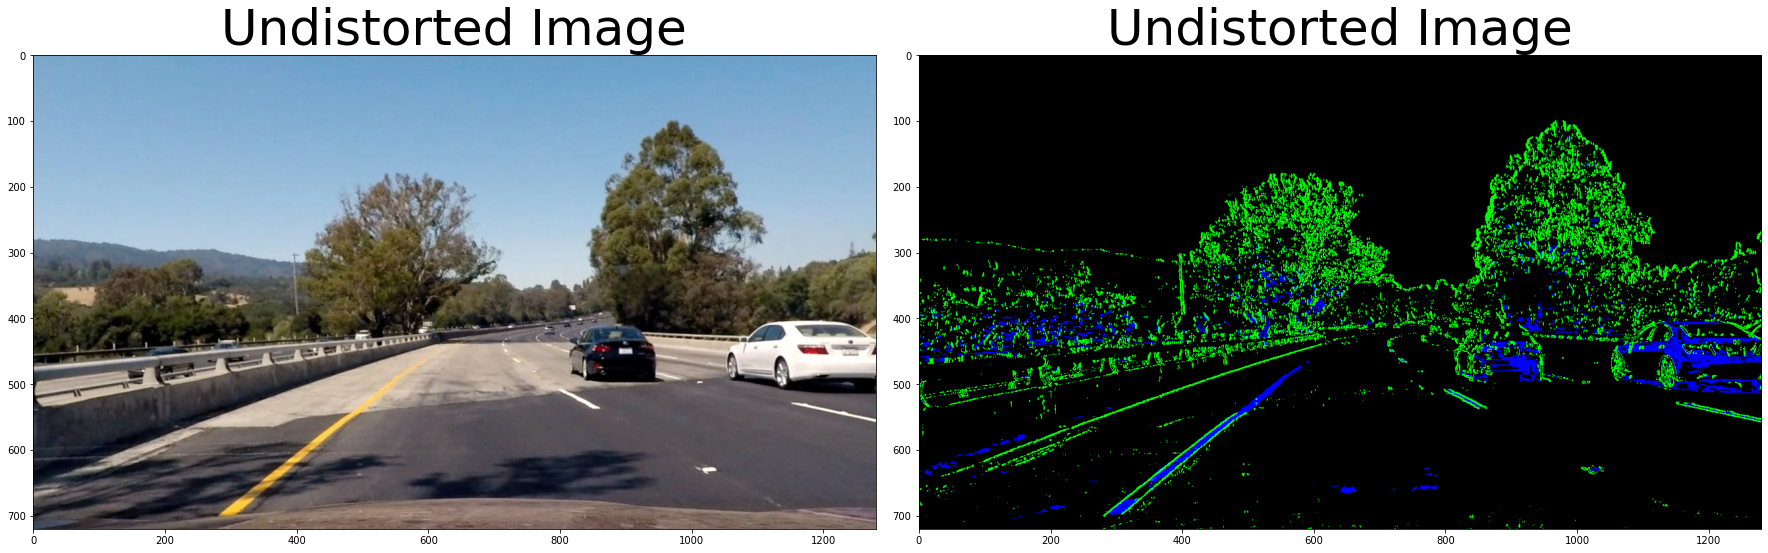

In [115]:
def pipelineHLSSobelxLChannelColorSThreshold(img0, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img0, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # build gray threshold binary
    resultBinary = np.zeros_like(scaled_sobel)
    resultBinary[((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])) |
                ((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]))] = 1
    # Stack each channel
    grayBnry = np.dstack(( resultBinary, resultBinary, resultBinary)) * 255
    
    return color_binary, grayBnry

# Make a list of undistorted test images
filenames = os.listdir(undistortedTestImgFolder)


for fname in filenames :

    # Read in image 
    undist = mpimg.imread(undistortedTestImgFolder + '/' + fname)
        
    colorBinary, grayBinary = pipelineHLSSobelxLChannelColorSThreshold(undist)

    saveImageOutputAndShowVsImageInput(thresholdedBinaryImgFolder, filenames, fname , undist, 'Undistorted Image',
                                       colorBinary, 'Undistorted Image')
    
    # extra to save gray image output.    
    # Convert gray scale only and save grayScale images
    # convert image to gray scale, 
    grayBinary = cv2.cvtColor(grayBinary,cv2.COLOR_RGB2GRAY)
    # save output images -- for Writeup illustrations
    mpimg.imsave(thresholdedBinaryImgGrayFolder + '/' + fname,grayBinary,cmap='gray')
    

## Apply a perspective transform to rectify binary image ("birds-eye view").

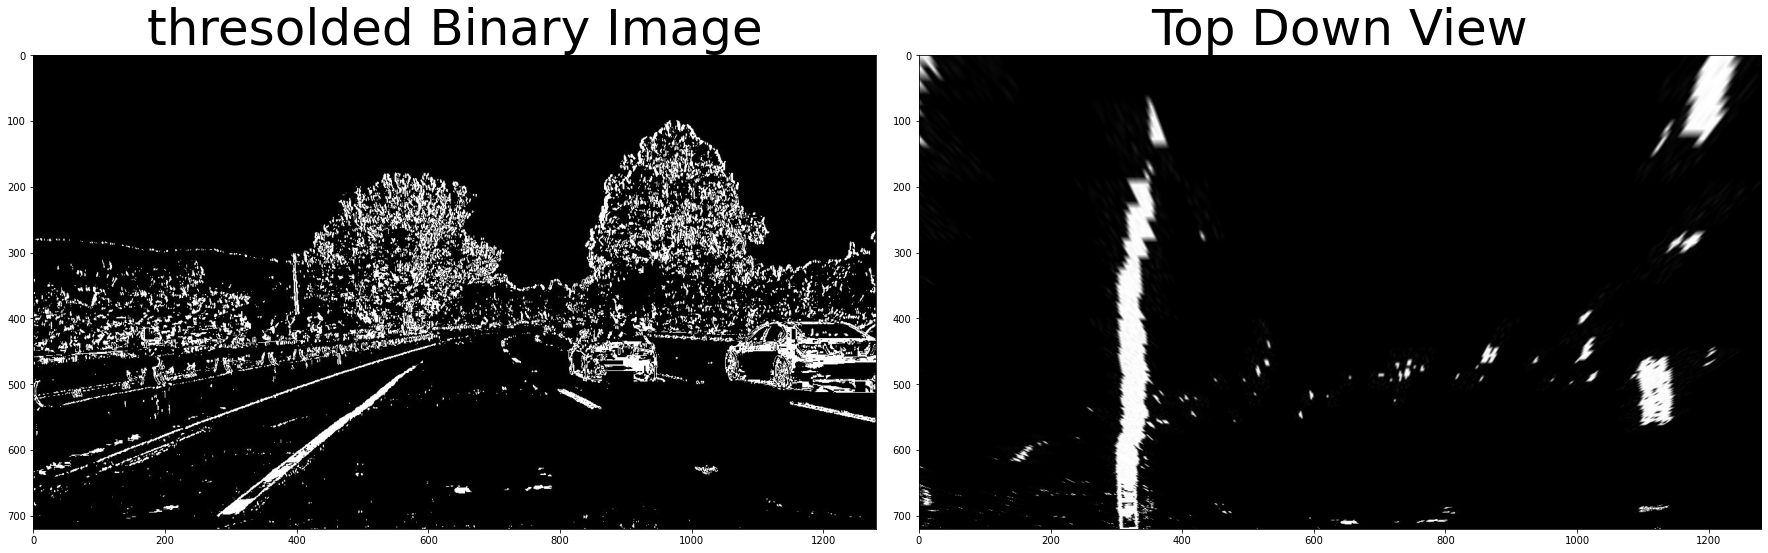

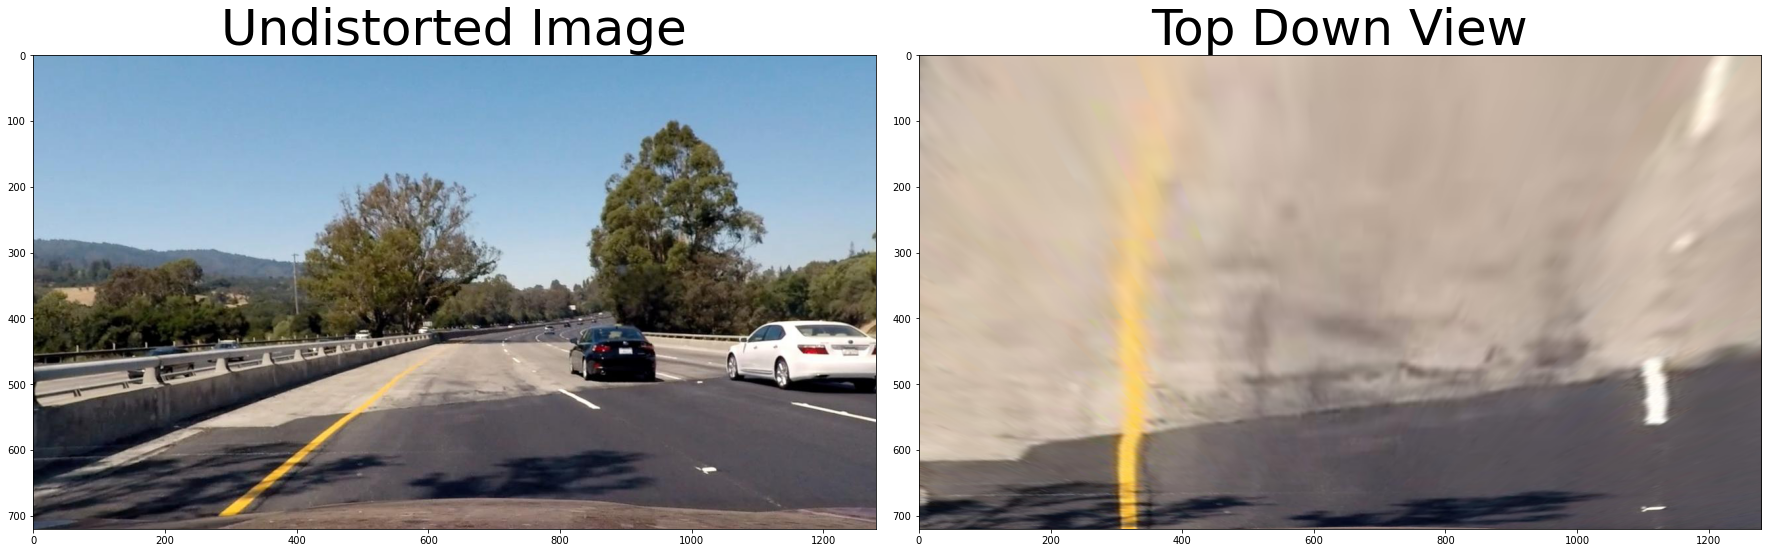

In [109]:

def warpImage(img):
    
    img_size = (xSize,ySize)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped

    
# Make a list of Thresholded Binary Images
filenames = os.listdir(thresholdedBinaryImgGrayFolder)


for fname in filenames :
    # Read in image 
    grayBinary = mpimg.imread(thresholdedBinaryImgGrayFolder + '/' + fname)
    undist = mpimg.imread(undistortedTestImgFolder + '/' + fname)
    
    top_downBinary = warpImage(grayBinary)
    top_down = warpImage(undist)

    # gray conversion of the top_downBinary otherwise it is making issues after
    # on img_out with 9 layers (3+3+3) with nb.dstack()
    # convert image to gray scale, 
    grayTopDownBinary = cv2.cvtColor(top_downBinary,cv2.COLOR_RGB2GRAY)  
    
    # save output images -- for Writeup illustrations
    if saveImages :
        mpimg.imsave(topDownViewBinaryFolder + '/' + fname,grayTopDownBinary,cmap='gray')
    if fname == filenames[0] :
        display2ImagesSideBySide(grayBinary,'thresolded Binary Image',top_downBinary,'Top Down View')
    
    saveImageOutputAndShowVsImageInput(topDownViewFolder, filenames, fname , undist, 'Undistorted Image',
                                       top_down, 'Top Down View')
    


## Detect lane pixels and fit to find the lane boundary.
### Half bottom image histogram to detect Left + Right lanes

number of Sliding Window Search : 1, number of Prior Line Search : 7


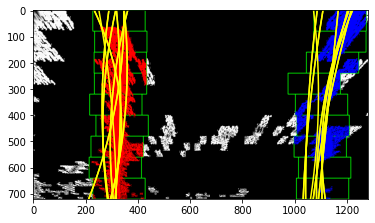

In [141]:
def find_lane_pixels_slidingWindows(binary_warped,display=False):

    global nbSlidingWindowSearch
    
    # counter frames using sliding window for lane search
    nbSlidingWindowSearch += 1

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if display :
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set up windows and window hyperparameters
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Iterate through nwindows to track curvature
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #print(str(out_img.shape))
        
        if display :
            
            # Draw the windows on the visualization image
            #print("image size" + str(binary_warped.shape) + " " + str(win_xleft_low) + " "+ str(win_y_low) + " " + str(win_xleft_high) + " " + str(win_y_high))
            cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #s
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    #end for
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if display :
        return leftx, lefty, rightx, righty, out_img
    else :
        return leftx, lefty, rightx, righty



def find_lane_pixels_fromPriorSearch(binary_warped, display=False):
    
    global nbPriorLineSearch
    # counter frames using Prior Line search lane search
    nbPriorLineSearch += 1

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if display :
        ## Visualization ##

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    if display :
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    if display :
        return leftx, lefty, rightx, righty, result
    else : 
        return leftx, lefty, rightx, righty
        
def updateLineObjectLineFound(linesFound, leftL, rightL, left_fit, right_fit, leftx, lefty, rightx, righty) :
    # Update leftLine and rightLine objects
    if linesFound :
        leftL.detected = True
        rightL.detected = True
        leftL.current_fit = left_fit
        rightL.current_fit = right_fit
    else :
        leftL.detected = False
        rightL.detected = False
        leftL.current_fit = np.zeros(3)
        rightL.current_fit = np.zeros(3) 
        '''
            SKIP SMOOTHING FOR TIME BEING
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        '''
    leftL.allx = leftx
    leftL.ally = lefty
    rightL.allx = rightx
    rightL.ally = righty

    return leftL, rightL
    # end updateLineObjectLineFound() 
        
# Fit a polynomial
def fit_polynomial(binary_warped,leftL,rightL,display=False):
    
    # If Lines not found in previous image --> find lane pixels via slinding Windows
    if (leftL.detected == False) or (rightL.detected == False) :
        #print('Using Sliding Window')
        # Find our lane pixels first
        if display :
            leftx, lefty, rightx, righty, out_img = find_lane_pixels_slidingWindows(binary_warped,display)
        else : 
            leftx, lefty, rightx, righty = find_lane_pixels_slidingWindows(binary_warped)
        
    else :    # Last image lanes/lines found 
        #--> can optimze with searchFromPriorImage()
        # Run image through the pipeline
        # Note that in your project, you'll also want to feed in the previous fits
        # Polynomial fit values from the previous frame
        # Make sure to grab the actual values from the previous step in your project!
        # left_fit <-- leftLine.current_fit
        # right_fit <--rightLine.current_fit
        
        #left_fitx, right_fitx, ploty = search_around_poly(binary_warped, leftLine.current_fit, rightLine.current_fit)
        #print('Using PriorSearchLines')
        # Find our lane pixels first
        #leftx, lefty, rightx, righty, out_img = find_lane_pixels_slidingWindows(binary_warped)
        if display :
            leftx, lefty, rightx, righty, out_img = find_lane_pixels_fromPriorSearch(binary_warped,display)
        else : 
            leftx, lefty, rightx, righty = find_lane_pixels_fromPriorSearch(binary_warped,False)

    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        linesFound = True
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        linesFound = False

        
    # fill left and right line objects accordingly.
    # left_fit, right_fit, --> lines polynomial parameters
    # ploty, 
    # lefty, leftx, righty, rightx, --> left and right lines pixel positions.
    # left_fitx, right_fitx -- x coordinates of left and right lines
    
    # Update leftLine, rightLine objects passed from one image to the other
    leftL, rightL = updateLineObjectLineFound(linesFound, leftL, rightL, left_fit, 
                              right_fit, leftx, lefty, rightx, righty) 
    
    
    if display : 
        return linesFound, out_img, left_fit, right_fit, ploty, lefty, leftx, righty, rightx, left_fitx, right_fitx, leftL, rightL
    else : 
        return linesFound, left_fit, right_fit, ploty, lefty, leftx, righty, rightx, left_fitx, right_fitx, leftL, rightL
    # end fit_polynomial()
    


# Make a list of Thresholded Binary Images
filenames = os.listdir(topDownViewBinaryFolder)

# Initialization of leftLine/rightLine objects for first image to process : 
rightLine.reset()
leftLine.reset()

# counter frames using sliding window for lane search
nbSlidingWindowSearch = 0
# counter frames using Prior Line search lane search
nbPriorLineSearch = 0

for fname in filenames :
    # Read in image
    grayTopDownBinary = mpimg.imread(topDownViewBinaryFolder + '/' + fname)
    
    # on img_out with 9 layers (3+3+3) with nb.dstack()
    # convert image to gray scale, 
    grayTopDownBinary = cv2.cvtColor(grayTopDownBinary,cv2.COLOR_RGB2GRAY)  
    
    linesFound, out_img, left_fit, right_fit, ploty, lefty, leftx,\
    righty, rightx, left_fitx, right_fitx, leftLine, rightLine  = fit_polynomial(grayTopDownBinary,leftLine,rightLine,display=True)
 
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # save and show output images -- for Writeup illustrations
    saveImageOutputAndShow(slidingWindowsLanePixelsBoundariesFolder, filenames, fname, out_img)
      
# images : (720, 1280, 3)

print(f'number of Sliding Window Search : {nbSlidingWindowSearch}, number of Prior Line Search : {nbPriorLineSearch}')


## Determine the curvature of the lane and vehicle position with respect to center.
### Measuring Curvature

In [142]:
    
def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, y_eval

def vehicle_position_vs_center(left_fit, right_fit, y_eval, picWidthPixels) :
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    #xleftmeters = left_fit[0]*((y_eval*ym_per_pix)**2) + left_fit[1]*y_eval*ym_per_pix + left_fit[2]
    #xrightmeters = right_fit[0]*((y_eval*ym_per_pix)**2) + right_fit[1]*y_eval*ym_per_pix + right_fit[2]
    xleft = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    xright = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    
    # Now we have to compare middle of (xleftmeters,xrightmeters) vs middle of the picture in meters
    #middlePicMeters = picWidthPixels*xm_per_pix/2
    #deviation_m = ((xrightmeters - xleftmeters)/2) - middlePicMeters
    middlePic = picWidthPixels/2
    deviation_m = ((xright + xleft)/2) - middlePic
    
    return (deviation_m*xm_per_pix)


# Sanity check on line detection.
    #• Checking that they have similar curvature
    #• Checking that they are separated by approximately the right distance horizontally
    #• Checking that they are roughly parallel
def getLineDetectSanitycheck(leftcurv, rightcurv) :
    status = False
    if (np.absolute(leftcurv-rightcurv) < np.minimum(leftcurv,rightcurv)) :
        status = True
    return status
    # end getLineDetectSanitycheck()
    
    
def getCurvatureAndDeviation(binary_warped_gray, left_fit, right_fit, ploty, leftL, rightL, linesF) :
       
   # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad, y_eval = measure_curvature_real(left_fit, right_fit, ploty)
    deviation = vehicle_position_vs_center(left_fit, right_fit, y_eval, binary_warped_gray.shape[1])
    
    # Sanity check on line detection.
    sanityCheckOK = getLineDetectSanitycheck(left_curverad, right_curverad)
    #print(f'file {fname} sanity : {sanityCheckOK}')
          
    # Reset
    # If your sanity checks reveal that the lane lines you've detected are problematic for 
    # some reason, you can simply assume it was a bad or difficult frame of video, retain 
    # the previous positions from the frame prior and step to the next frame to search again. 
    # If you lose the lines for several frames in a row, you should probably start searching 
    # from scratch using a histogram and sliding window, or another method, to re-establish 
    # your measurement.
    if not sanityCheckOK : 
        leftL.detected = False
        rightL.detected = False
        # will trigger sliding window detection for next image frame.
        
        
    # update Line objects curvature values to pass from image to image
    if linesF and sanityCheckOK :
        # fill Line objects
        leftL.radius_of_curvature = left_curverad  
        rightL.radius_of_curvature = right_curverad
    
    return left_curverad, right_curverad, y_eval, deviation, leftL, rightL


    
# Make a list of Thresholded Binary Images
filenames = os.listdir(topDownViewBinaryFolder)

# Initialization of leftLine/rightLine objects for first image to process : 
rightLine.reset()
leftLine.reset()

# counter frames using sliding window for lane search
nbSlidingWindowSearch = 0
# counter frames using Prior Line search lane search
nbPriorLineSearch = 0


for fname in filenames :
    # Read in image
    grayTopDownBinary = mpimg.imread(topDownViewBinaryFolder + '/' + fname)
    
    # on img_out with 9 layers (3+3+3) with nb.dstack()
    # convert image to gray scale, 
    grayTopDownBinary = cv2.cvtColor(grayTopDownBinary,cv2.COLOR_RGB2GRAY)  
    
    linesFound, left_fit, right_fit, ploty, lefty, leftx,\
    righty, rightx, left_fitx,\
    right_fitx, leftLine, rightLine  = fit_polynomial(grayTopDownBinary,leftLine,rightLine,display=False)

    left_curverad, right_curverad, y_eval, deviation,\
    leftLine, rightLine = getCurvatureAndDeviation(grayTopDownBinary,
                                                   left_fit, right_fit, ploty,
                                                   leftLine, rightLine, linesFound)
       
    print(f'left_curv {int(left_curverad):6} m, right_curv {int(right_curverad):6} m, deviation {deviation:0.2f} m')
    
    
    
    # Should see values of 533.75 and 648.16 here, if using
    # the default `generate_data` function with given seed number

print(f'number of Sliding Window Search : {nbSlidingWindowSearch}, number of Prior Line Search : {nbPriorLineSearch}')


left_curv   3635 m, right_curv   1556 m, deviation 0.36 m
left_curv   2359 m, right_curv   3232 m, deviation 0.28 m
left_curv   2264 m, right_curv   5387 m, deviation 0.09 m
left_curv   2508 m, right_curv  28153 m, deviation 0.11 m
left_curv   4595 m, right_curv   2616 m, deviation 0.37 m
left_curv   2132 m, right_curv   5019 m, deviation 0.25 m
left_curv   5076 m, right_curv   3041 m, deviation 0.11 m
left_curv   2767 m, right_curv   2506 m, deviation 0.22 m
number of Sliding Window Search : 5, number of Prior Line Search : 3


## Warp the detected lane boundaries back onto the original image

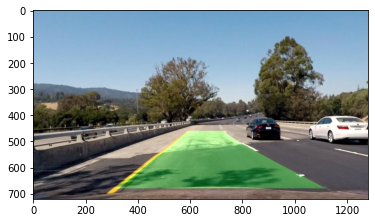

In [131]:

def addLaneBoundaries(binary_warped_gray, undist_img, left_fitx, right_fitx, ploty) :
    
    # warp detected lane boudaries back onto original image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_gray).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (xSize,ySize)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result



# Make a list of Thresholded Binary Images
filenames = os.listdir(topDownViewBinaryFolder)

# Initialization of leftLine/rightLine objects for first image to process : 
rightLine.reset()
leftLine.reset()

for fname in filenames :
    # Read in binary_warped image
    grayTopDownBinary = mpimg.imread(topDownViewBinaryFolder + '/' + fname)
    # Read original undistorted image
    undist = mpimg.imread(undistortedTestImgFolder + '/' + fname)
    
    # on img_out with 9 layers (3+3+3) with nb.dstack()
    # convert image to gray scale, 
    grayTopDownBinary = cv2.cvtColor(grayTopDownBinary,cv2.COLOR_RGB2GRAY)  
    
    linesFound, left_fit, right_fit, ploty, lefty, leftx,\
    righty, rightx, left_fitx, right_fitx, leftLine, rightLine  = fit_polynomial(grayTopDownBinary,leftLine,rightLine,display=False)
    
    undistBoundaryLanesImg = addLaneBoundaries(grayTopDownBinary, undist, left_fitx, right_fitx, ploty)
    
    # save and show output images -- for Writeup illustrations
    saveImageOutputAndShow(detectedLaneBoundariesFolder, filenames, fname, undistBoundaryLanesImg)
    
        

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

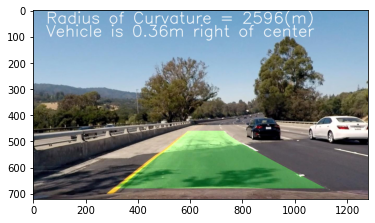

In [132]:

def addCurveDeviationOverlay(laneBoundaryImg, left_fit, right_fit, ploty,left_curverad, right_curverad, deviation) :
    
    curv_avg = int((left_curverad+right_curverad)/2)
    
    # print radius in overlay on boundaryLaneImage ...
    # Radius of curvature = xxxx(m)
    # Vehicule is x.xxm left/right of center
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    if deviation <= 0 :
        side = 'left'
    else : 
        side = 'right'
    txt1 = f'Radius of Curvature = {curv_avg}(m)'
    txt2 = f'Vehicle is {np.absolute(deviation):.2f}m {side} of center'
    
    # cv2.putText(image, text, org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
    cv2.putText(laneBoundaryImg, txt1, (50,50), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(laneBoundaryImg, txt2, (50,100), font, 2, (255, 255, 255), 2, cv2.LINE_AA)

    return laneBoundaryImg


# Make a list of Images with Lane Boundaries
filenames = os.listdir(detectedLaneBoundariesFolder)

# Initialization of leftLine/rightLine objects for first image to process : 
rightLine.reset()
leftLine.reset()

for fname in filenames :
    
    # Read image with boundary lanes
    undistBoundaryLanesImg = mpimg.imread(detectedLaneBoundariesFolder + '/' + fname)
    
    # Read in binary warped image
    grayTopDownBinary = mpimg.imread(topDownViewBinaryFolder + '/' + fname)
    
    # make sure gray dimensions / convert to gray scale
    grayTopDownBinary = cv2.cvtColor(grayTopDownBinary,cv2.COLOR_RGB2GRAY)  
    
    linesFound, left_fit, right_fit, ploty, lefty, leftx,\
    righty, rightx, left_fitx, right_fitx,\
    leftLine, rightLine  = fit_polynomial(grayTopDownBinary,leftLine,rightLine,display=False)

    
    left_curverad, right_curverad, y_eval, deviation,\
    leftLine, rightLine = getCurvatureAndDeviation(grayTopDownBinary,left_fit, right_fit,
                                                   ploty, leftLine, rightLine, linesFound)
    
    laneBoundaryImg = addCurveDeviationOverlay(undistBoundaryLanesImg,
                                              left_fit, right_fit, ploty, left_curverad, right_curverad,
                                              deviation)
    
    # save and show output images -- for Writeup illustrations
    saveImageOutputAndShow(imgBoundariesTextFolder, filenames, fname, laneBoundaryImg)
    


# Re-design for image pipeline

number of Sliding Window Search : 4, number of Prior Line Search : 4


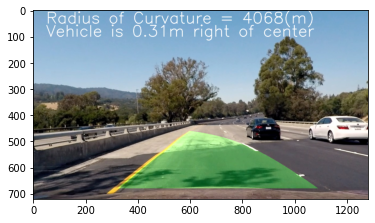

In [143]:
def cameraCalibration() :
    # images for camera calibration are stored in the folder called `camera_cal`.  
    # need to set your chessboard size to 9x6 for the project instead of 8x6 as in the lesson.

    # multiple pictures of the chessboard against a flat surface, 
    # then we’ll be able to detect any distortions by  looking at the difference between apparent 
    # size and the shape of squares in these images, and the size and shape that they actually are.
    #    • Then we’ll use that information to calibrate our camera.
    #    • Create a transform that maps distorted point to undistorded points.
    #    • And finally, undistort any images.
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Make a list of calibration images
    #images = glob.glob('camera_cal/calibration*.jpg')
    filenames = os.listdir(cameraCalFolder)

    # Step through the list and search for chessboard corners
    for fname in filenames :
        img = mpimg.imread(cameraCalFolder + '/' + fname)

        ret, corners, objpoints, imgpoints = findChessboardCorners(img, objpoints, imgpoints)

    # Now based on al objpoints + imgpoints, will compute camera calibration matrix 
    # and distortion coefficients (mtx and dist)
    ret, mtx, dist, rvecs, tvers = cv2.calibrateCamera(objpoints,imgpoints,(xSize,ySize),None,None)  
    
    return mtx, dist
    # end cameraCalibration()


    
def process_image(img):
    global leftLine, rightLine
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # DONE: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.    
    colorBinary, grayBinary = pipelineHLSSobelxLChannelColorSThreshold(undist)
       
    # convert image to gray scale, 
    grayBinary = cv2.cvtColor(grayBinary,cv2.COLOR_RGB2GRAY)
    
    
    # Apply a perspective transform to rectify binary image ("birds-eye view")
    grayTopDownBinary = warpImage(grayBinary)
        
    # Detect lane pixels and fit to find the lane boundary.
    # Half bottom image histogram to detect Left + Right lanes¶    
    linesFound, left_fit, right_fit, ploty, lefty, leftx,\
    righty, rightx, left_fitx, right_fitx,\
    leftLine, rightLine  = fit_polynomial(grayTopDownBinary,leftLine,rightLine,display=False)
    
    # Curvature and Deviation calculation
    left_curverad, right_curverad, y_eval, deviation,\
    leftLine, rightLine = getCurvatureAndDeviation(grayTopDownBinary,left_fit,
                                                   right_fit, ploty, leftLine, rightLine, linesFound)
    
    
    
    # Warp the detected lane boundaries back onto the original image (undist)
    undistBoundaryLanesImg = addLaneBoundaries(grayTopDownBinary, undist, left_fitx, right_fitx, ploty)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    laneBoundaryImg = addCurveDeviationOverlay(undistBoundaryLanesImg, left_fit, right_fit,
                                               ploty, left_curverad, right_curverad, deviation)
    
    return laneBoundaryImg
    # end process_image()


    
#### MAIN IMAGE PIPELINE IMPLEMENTATION

mtx, dist = cameraCalibration()

# Make a list of test images
filenames = os.listdir(testImageFolder)

# Initialization of leftLine/rightLine objects for first image to process : 
rightLine.reset()
leftLine.reset()

# counter frames using sliding window for lane search
nbSlidingWindowSearch = 0
# counter frames using Prior Line search lane search
nbPriorLineSearch = 0

for fname in filenames :

    # Read in image 
    img = mpimg.imread(testImageFolder + '/' + fname)
    
    laneBoundaryImg = process_image(img)
    
    # save and show output images -- for Writeup illustrations
    saveImageOutputAndShow(imgBoundariesTextFolder, filenames, fname, laneBoundaryImg)

print(f'number of Sliding Window Search : {nbSlidingWindowSearch}, number of Prior Line Search : {nbPriorLineSearch}')
    
    
    

## Test on Videos


In [144]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Initialization of leftLine/rightLine objects for first image to process : 
rightLine.reset()
leftLine.reset()

# counter frames using sliding window for lane search
nbSlidingWindowSearch = 0
# counter frames using Prior Line search lane search
nbPriorLineSearch = 0

white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

print(f'number of Sliding Window Search : {nbSlidingWindowSearch}, number of Prior Line Search : {nbPriorLineSearch}')


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 8min, sys: 36.4 s, total: 8min 36s
Wall time: 9min 29s
number of Sliding Window Search : 617, number of Prior Line Search : 644


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [136]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))